# Introdução

Spam de email ou lixo eletrônico é um tipo de spam que se utiliza o email para o envio de mensagens indesejadas, ou seja, que não foram solicitadas pelo destinatário. Além disso, eles servem como vetor para ataques tipo phishing ou mesmo golpes cada vez mais elaborados por estelionatários. Por dia, estima-se que mais de 100 bilhões de spams são enviados por e-mail.

**O que desejo é que o e-mail precisa ser classificado como spam ou ham com base no conteúdo do e-mail.**

# Sobre os Dados

Link para o database: https://spamassassin.apache.org/old/publiccorpus/

O Spam Assassin Dataset é uma seleção de mensagens de e-mail, adequado para uso em testes de sistemas de filtragem de spam. Este conjunto específico foi obtido do Apache Public Datasets , limpo e organizado em um arquivo csv de uma maneira que possa ser conveniente de usar.

O conjunto de dados é a combinação de ```spam```, ```spam_2```, ```easy_ham``` e ```easy_ham_2```.

Os e-mails de spam:

* O ```spam``` conteúdo continha 500 mensagens de spam, todas recebidas de fontes não spam-trap.
* O ```spam_2``` continha 1397 mensagens de spam. Estes são mais recentes.

Os e-mails não spam: 

* O ```easy_ham``` continha 2500 mensagens não spam. Normalmente, é muito fácil diferenciá-los de spam, pois frequentemente não contêm assinaturas "spam" (como HTML, etc.).
* O ```easy_ham_2``` continha 1400 mensagens não spam. Como spam_2 uma adição mais recente ao conjunto.

# Análise Exploratória de Dados

## Importação das bibliotecas básicas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

## Base de Dados

In [2]:
base_emails = pd.read_csv('data/spam_assassin.csv')

In [3]:
base_emails

,text,target
0,From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...,0
1,From gort44@excite.com Mon Jun 24 17:54:21 200...,1
2,From fork-admin@xent.com Mon Jul 29 11:39:57 2...,1
3,From dcm123@btamail.net.cn Mon Jun 24 17:49:23...,1
4,From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...,0
...,...,...
5791,From ilug-admin@linux.ie Mon Jul 22 18:12:45 2...,0
5792,From fork-admin@xent.com Mon Oct 7 20:37:02 20...,0
5793,Received: from hq.pro-ns.net (localhost [127.0...,1
5794,From razor-users-admin@lists.sourceforge.net T...,0


O conjunto de dados contém 2 colunas "Text" que representa o corpo do email e "target" que é sua classificação.

In [4]:
base_emails.describe()

,target
count,5796.000000
mean,0.327122
std,0.469203
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Pela média, percebe-se que a base de dados é desbalanceada, ou seja, há muitos mais emails classifcados como ham do que como spam

[Text(0, 0, '3900'), Text(0, 0, '1896')]

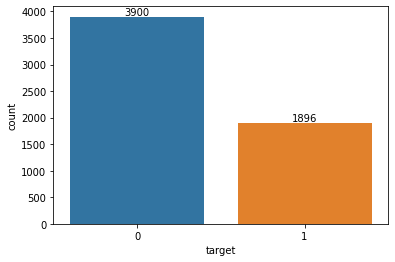

In [5]:
ax = sns.countplot(x = base_emails['target'])
ax.bar_label(container= ax.containers[0], labels = base_emails['target'].value_counts(ascending=False).values)

### Verificando Valores Faltantes

In [6]:
base_emails.isnull().sum()

text      0
target    0
dtype: int64

Perfeito, não há dados faltantes na base de dados

### Divisão entre Previsores e Classe

In [7]:
X_emails = base_emails.iloc[:, 0].values #text
X_emails[0]

"From ilug-admin@linux.ie Mon Jul 29 11:28:02 2002 Return-Path: <ilug-admin@linux.ie> Delivered-To: yyyy@localhost.netnoteinc.com Received: from localhost (localhost [127.0.0.1]) by phobos.labs.netnoteinc.com (Postfix) with ESMTP id A13D94414F for <jm@localhost>; Mon, 29 Jul 2002 06:25:11 -0400 (EDT) Received: from phobos [127.0.0.1] by localhost with IMAP (fetchmail-5.9.0) for jm@localhost (single-drop); Mon, 29 Jul 2002 11:25:11 +0100 (IST) Received: from lugh.tuatha.org (root@lugh.tuatha.org [194.125.145.45]) by dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g6RHn7i17130 for <jm-ilug@jmason.org>; Sat, 27 Jul 2002 18:49:07 +0100 Received: from lugh (root@localhost [127.0.0.1]) by lugh.tuatha.org (8.9.3/8.9.3) with ESMTP id SAA25016; Sat, 27 Jul 2002 18:45:03 +0100 X-Authentication-Warning: lugh.tuatha.org: Host root@localhost [127.0.0.1] claimed to be lugh Received: from mail1.mail.iol.ie (mail1.mail.iol.ie [194.125.2.192]) by lugh.tuatha.org (8.9.3/8.9.3) with ESMTP id SAA24977 f

In [8]:
y_emails = base_emails.iloc[:, 1].values #target
y_emails[0]

0

### Divisão das bases em treinamento e teste

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_emails_treinamento, X_emails_teste, y_emails_treinamento, y_emails_teste = train_test_split(X_emails, y_emails, test_size = 0.25, random_state = 0)

In [11]:
print("Base Total: ", np.shape(base_emails))
print("Base de Treino: ", np.shape(X_emails_treinamento))
print("Base de Teste: ", np.shape(X_emails_teste))

Base Total:  (5796, 2)
Base de Treino:  (4347,)
Base de Teste:  (1449,)


### Limpeza nos Corpos dos Emails

A primeira coisa que devemos fazer ao tratar com o corpo dos emails é retirar as palavras irrelevantes e sem sentido.

Para isso, vamos utilizar a biblioteca ```nltk```, que fornece um conjunto de bibliotecas e programas para processamento simbólico e estatístico de linguagem natural para inglês. O que iremos pegar dela é uma lista de stopwords para removermos dos nossos emails.

Além disso, usaremos o Vetorizador TF-IDF do scikit-learn. Este é um algoritmo muito comum para transformar texto em uma representação significativa de números que é usada para ajustar o algoritmo da máquina para previsão. 

$$TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)$$

* **Term Frequency (TF)** — sklearn usa o número de vezes que um termo ‘t’ aparece em um documento.


* **Frequência inversa do documento (IDF)** idf é uma medida de quão comum ou raro um termo é em todo os documentos. Portanto, o ponto a ser observado é que é comum a todos os documentos. Se a palavra for comum e aparecer em muitos documentos, o valor idf (normalizado) se aproximará de 0 ou se aproximará de 1 se for raro.

A ideia é criar uma coluna para cada palavra e colocar a frequência que ela aparece na mensagem do email.

In [12]:
import pickle
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
tfidf = TfidfVectorizer(stop_words=stop_words, token_pattern=r'(?u)\b([a-zA-Z]{4,20})\b', use_idf=True)
tfidf.fit(X_emails_treinamento)
X_emails_treinamento = tfidf.transform(X_emails_treinamento)

In [15]:
print("Sparse Matrix form of test data : \n")
print(X_emails_treinamento.todense(), "\n")

print(f"Há {np.shape(X_emails_treinamento.todense()[0])[1]} palavras(colunas).")

Sparse Matrix form of test data : 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

Há 40615 palavras(colunas).


# Escolher Algoritmo de Classificação

Vamos aplicar esses 5 algoritmos de classificação:
    

* Arvore de Decisão
* Random Forest
* Knn
* Regressão logística
* SVM

Como essa parte demora, basta rodar uma vez e saberemos o melhor algoritmo para esse projeto. E o algoritmo escolhido foi o **Random Forest**.

## Tuning dos parâmetros com GridSearch

In [16]:
from sklearn.model_selection import GridSearchCV

O GridSearchCV é uma ferramenta usada para automatizar o processo de ajuste dos parâmetros de um algoritmo, pois ele fará de maneira sistemática diversas combinações dos parâmetros e depois de avaliá-los os armazenará num único objeto.

Às vezes, ao rodar o código, os parâmetros escolhidos são diferentes. Isso ocorre pq os dados selecionados são sempre escolhidos ao acaso.
De qualquer forma, os que aparecem possuem resultados semelhantes

### Arvore de Decisão

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
parametros = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'min_samples_split': [2, 5, 10], 
              'min_samples_leaf': [1, 5, 10]}

In [19]:
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parametros)
grid_search.fit(X_emails_treinamento, y_emails_treinamento)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
0.9786064045077577


### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
parametros = {'criterion': ['gini', 'entropy'],
              'n_estimators': [10, 40, 100, 150],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10]}

In [22]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros)
grid_search.fit(X_emails_treinamento, y_emails_treinamento)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.9857373384654048


### Knn

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
parametros = {'n_neighbors': [3, 5, 10, 20],
              'p': [1, 2]}

In [25]:
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parametros)
grid_search.fit(X_emails_treinamento, y_emails_treinamento)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'n_neighbors': 3, 'p': 2}
0.9700945729666813


### Regressão logística


In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
parametros = {'tol': [0.0001, 0.00001, 0.000001],
              'C': [1.0, 1.5, 2.0],
              'solver': ['lbfgs', 'sag', 'saga']}

In [28]:
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=parametros)
grid_search.fit(X_emails_treinamento, y_emails_treinamento)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'C': 2.0, 'solver': 'lbfgs', 'tol': 0.0001}
0.9813666124360145


### SVM

In [29]:
from sklearn.svm import SVC

In [30]:
parametros = {'tol': [0.001, 0.0001, 0.00001],
              'C': [1.0, 1.5, 2.0],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

In [31]:
grid_search = GridSearchCV(estimator=SVC(), param_grid=parametros)
grid_search.fit(X_emails_treinamento, y_emails_treinamento)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'C': 1.5, 'kernel': 'linear', 'tol': 0.001}
0.992868272423052


## Validação Cruzada

É muito comum quando estamos iniciando com Data Science e Machine Learning dividirmos nosso conjunto de dados em dados de treino e teste.

Agora pensem comigo… Se eu dividir o mesmo modelo novamente com a mesma porcentagem (%) para treino e teste e depois executar o meu modelo (com os dados de treino é claro), vou ter o mesmo resultado?

Os dados são divididos aleatóriamente para treino e teste. Ou seja, os dados que antes eram utilizados para teste agora podem está sendo utilizados para treino e vice-versa.

![](https://miro.medium.com/max/750/1*Hn-BqSHWwA3-iwAnTamDxA.webp)

o K-Fold do sklearn faz essa separação para nós, então como visto na imagem, ele pegará nossos dados de trainamento e fará várias divisões e treinamentos.


In [32]:
from sklearn.model_selection import cross_val_score, KFold

In [33]:
resultados_arvore = []
resultados_random_forest = []
resultados_knn = []
resultados_logistica = []
resultados_svm = []
resultados_rede_neural = []

for i in range(30): #Vamos realizar 30 testes(cada teste é a média de 10 testes de cada algoritmo)
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)

    arvore = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5, min_samples_split=5, splitter="random")
    scores = cross_val_score(arvore, X_emails_treinamento, y_emails_treinamento, cv = kfold)
    resultados_arvore.append(scores.mean())

    random_forest = RandomForestClassifier(criterion='gini', min_samples_leaf=1, min_samples_split=2, n_estimators=100)
    scores = cross_val_score(random_forest, X_emails_treinamento, y_emails_treinamento, cv = kfold)
    resultados_random_forest.append(scores.mean())
    
    knn = KNeighborsClassifier(n_neighbors = 3, p = 2)
    scores = cross_val_score(knn, X_emails_treinamento, y_emails_treinamento, cv = kfold)
    resultados_knn.append(scores.mean())
    
    logistica = LogisticRegression(C = 2.0, solver = 'lbfgs', tol = 0.0001)
    scores = cross_val_score(logistica, X_emails_treinamento, y_emails_treinamento, cv = kfold)
    resultados_logistica.append(scores.mean())
    
    svm = SVC(kernel = 'linear', C = 1.5, tol=0.001)
    scores = cross_val_score(svm, X_emails_treinamento, y_emails_treinamento, cv = kfold)
    resultados_svm.append(scores.mean())

In [34]:
resultados = pd.DataFrame({'Arvore': resultados_arvore, 'Random Forest': resultados_random_forest,
                           'KNN': resultados_knn, 'Logistica': resultados_logistica,
                           'SVM': resultados_svm})
resultados

,Arvore,Random Forest,KNN,Logistica,SVM
0,0.969867,0.985510,0.973544,0.982057,0.992412
1,0.970551,0.985279,0.971475,0.982290,0.993331
2,0.972854,0.987120,0.974693,0.982518,0.993328
3,0.969405,0.985738,0.973085,0.981826,0.992409
4,0.971018,0.986886,0.974467,0.982746,0.992638
5,0.971239,0.986888,0.972625,0.982517,0.992638
6,0.968024,0.987121,0.972627,0.982289,0.992640
7,0.973539,0.987116,0.973083,0.982056,0.992636
8,0.971932,0.986427,0.974003,0.982517,0.991717
9,0.970319,0.985503,0.973082,0.982515,0.992408


## Análise dos algorítmos 

In [35]:
resultados.describe()

,Arvore,Random Forest,KNN,Logistica,SVM
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.971037,0.986489,0.973522,0.982317,0.992761
std,0.002830,0.000707,0.000940,0.000324,0.000482
min,0.965499,0.984815,0.971475,0.981825,0.991488
25%,0.969405,0.986024,0.973083,0.982057,0.992468
50%,0.971128,0.986542,0.973544,0.982289,0.992641
75%,0.973198,0.987055,0.973944,0.982517,0.993099
max,0.975848,0.987578,0.975851,0.982977,0.993331


### Teste de normalidade nos resultados

Vamos verificar se os nossos resustados de cada algoritmo representa uma distribuição normal.

Isso será importante para aplicar a ANOVA e o teste de Tukey para avaliar qual o melhor algoritmo.

In [36]:
alpha = 0.05

In [37]:
from scipy.stats import shapiro

In [38]:
shapiro(resultados_arvore), shapiro(resultados_random_forest), shapiro(resultados_knn), shapiro(resultados_logistica), shapiro(resultados_svm)


(ShapiroResult(statistic=0.9725775122642517, pvalue=0.6118349432945251),
 ShapiroResult(statistic=0.9613456130027771, pvalue=0.3351516127586365),
 ShapiroResult(statistic=0.9691241979598999, pvalue=0.5154971480369568),
 ShapiroResult(statistic=0.9353036880493164, pvalue=0.06802060455083847),
 ShapiroResult(statistic=0.9011980295181274, pvalue=0.008985988795757294))

### Teste de hipótese com ANOVA e Tukey

### Anova

A Análise de Variância ( ANOVA ) é uma fórmula estatística usada para comparar as variâncias entre as medianas (ou médias) de grupos diferentes. Diversos cenários usam ANOVA para determinar se há alguma diferença entre as medianas dos diferentes grupos.

O resultado da ANOVA é a 'estatística F'. Esta razão mostra a diferença entre a variância dentro do grupo e a variância entre os grupos, o que acaba por produzir um valor que permite concluir que a hipótese nula é suportada ou rejeitada. Se houver uma diferença significativa entre os grupos, a hipótese nula não é suportada e o F-ratio será maior.

* **Uma hipótese nula (H0)**: É quando não há diferença entre os grupos ou médias. Dependendo do resultado do teste ANOVA, a hipótese nula será aceita ou rejeitada.


* **Uma hipótese alternativa (H1)**: Quando teoricamente pensamos que existe uma diferença entre grupos e médias.

In [39]:
from scipy.stats import f_oneway

In [40]:
_, p = f_oneway(resultados_arvore, resultados_random_forest, resultados_knn, resultados_logistica, resultados_svm)
p 

2.575716905811569e-111

In [41]:
alpha = 0.05
if p <= alpha:
  print('Hipótese nula rejeitada. Dados são diferentes') #Ou seja, tem diferença entre os algoritmos 
else:
  print('Hipótese alternativa rejeitada. Resultados são iguais') #Ou seja, não tem diferença entre qual algoritmo escolher

Hipótese nula rejeitada. Dados são diferentes


In [43]:
resultados_algoritmos = {'accuracy': np.concatenate([resultados_arvore, resultados_random_forest, resultados_knn, resultados_logistica, resultados_svm, resultados_rede_neural]),
                         'algoritmo': ['arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore','arvore', 
                          'random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest','random_forest', 
                          'knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn','knn', 
                          'logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica','logistica',
                          'svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm','svm']}

In [44]:
resultados_df = pd.DataFrame(resultados_algoritmos)
resultados_df

,accuracy,algoritmo
0,0.969867,arvore
1,0.970551,arvore
2,0.972854,arvore
3,0.969405,arvore
4,0.971018,arvore
...,...,...
145,0.993099,svm
146,0.991488,svm
147,0.993329,svm
148,0.993097,svm


### Teste de Tukey

A ANOVA só pode dizer se há uma diferença significativa entre as medianas de pelo menos dois grupos, mas não pode explicar qual par difere em suas medianas. Se houver uma necessidade de dados granulares, a implantação de mais processos estatísticos de acompanhamento ajudará a descobrir quais grupos diferem em valor mediano. Normalmente, ANOVA é usada em combinação com outros métodos estatísticos.

Nesse caso, o resultado evidencia que a distribuição de pelo menos um dos grupos se difere das demais, mas não indica entre quais grupos a diferença é significativa. Assim, se faz necessário utilizar testes de comparações múltiplas e hoje, abordaremos um deles: o Teste de Tukey.

O Teste de Tukey consiste em comparar todos os possíveis pares de médias e se baseia na diferença mínima significativa (D.M.S.), considerando os percentis do grupo. No cálculo da D.M.S. utiliza-se também a distribuição da amplitude estudentizada, o quadrado médio dos resíduos da ANOVA e o tamanho amostral dos grupos.

O teste pode ser interpretado com base no valor da diferença mínima significativa (D.M.S.), no intervalo de confiança e no valor-p.

In [45]:
#!pip install statsmodels
from statsmodels.stats.multicomp import MultiComparison

In [46]:
compara_algoritmos = MultiComparison(resultados_df['accuracy'], resultados_df['algoritmo'])

In [47]:
teste_estatistico = compara_algoritmos.tukeyhsd()
print(teste_estatistico)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
    group1        group2    meandiff p-adj lower  upper  reject
---------------------------------------------------------------
       arvore           knn   0.0025   0.0 0.0015 0.0035   True
       arvore     logistica   0.0113   0.0 0.0103 0.0123   True
       arvore random_forest   0.0155   0.0 0.0145 0.0164   True
       arvore           svm   0.0217   0.0 0.0207 0.0227   True
          knn     logistica   0.0088   0.0 0.0078 0.0098   True
          knn random_forest    0.013   0.0  0.012  0.014   True
          knn           svm   0.0192   0.0 0.0182 0.0202   True
    logistica random_forest   0.0042   0.0 0.0032 0.0052   True
    logistica           svm   0.0104   0.0 0.0094 0.0114   True
random_forest           svm   0.0063   0.0 0.0053 0.0073   True
---------------------------------------------------------------


In [48]:
resultados.mean()

Arvore           0.971037
Random Forest    0.986489
KNN              0.973522
Logistica        0.982317
SVM              0.992761
dtype: float64

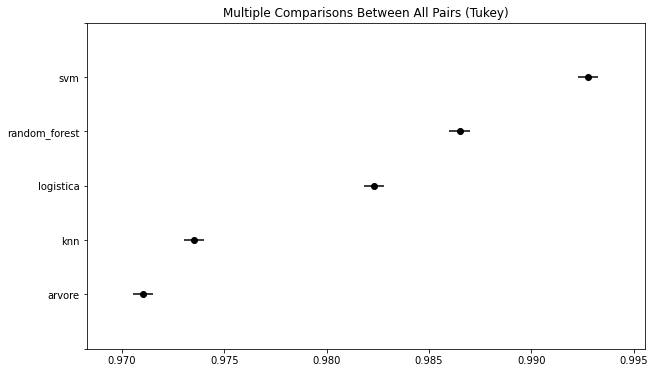

In [49]:
teste_estatistico.plot_simultaneous();

# Aplicando a 

In [ ]:
tfidf = TfidfVectorizer(stop_words=stop_words, token_pattern=r'(?u)\b([a-zA-Z]{4,20})\b')
tfidf.fit(X_emails_teste)
X_emails_teste = tfidf.transform(X_emails_teste)